In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
""" Read Data and create the train, validation and test sets """


train_data = pd.read_csv("regression-tabular-california-housing/train.csv", header= 0, index_col=0)
train_data["RegVal"] = train_data["MedHouseVal"]
train_data = train_data.drop(columns = ["MedHouseVal"])

test_data = pd.read_csv("regression-tabular-california-housing/test.csv", header= 0, index_col= 0)

X = train_data.drop(columns=["RegVal"])
y = train_data["RegVal"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# train / val sets
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset   = lgb.Dataset(X_val,   label=y_val, reference=train_dataset)
test_dataset = lgb.Dataset(train_data,label= None)


CAP = float(train_data["RegVal"].max())
FLOOR = float(train_data["RegVal"].min())

# your hyperparameters (set as you like)
lambda_cap = y.count()/y[y==CAP].count() * 0.20
lambda_floor = y.count()/y[y==FLOOR].count() * 0
print(lambda_cap)
print(lambda_floor)

4.065353037766831
0.0


In [3]:
def capped_mse_obj_exact_lgb(y_pred, dataset):
    """
    LightGBM custom objective for capped MSE.
    """
    y_true = dataset.get_label().astype(np.float64)
    p = y_pred.flatten().astype(np.float64)

    # Base MSE grad/hess
    grad = 2.0 * (p - y_true)                 
    hess = np.full_like(p, 2.0, dtype=np.float64)

    # boolean masks (use isclose for float safety)
    cap_mask = np.isclose(y_true, CAP)
    floor_mask = np.isclose(y_true, FLOOR)

    if np.any(cap_mask):
        grad[cap_mask] += 2.0 * lambda_cap * (p[cap_mask] - CAP)
        hess[cap_mask] += 2.0 * lambda_cap

    if np.any(floor_mask):
        grad[floor_mask] += 2.0 * lambda_floor * (p[floor_mask] - FLOOR)
        hess[floor_mask] += 2.0 * lambda_floor

    return grad, hess


def rmse_metric(y_pred, dataset):
    y_true = dataset.get_label()
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return "rmse", rmse, False  # name, value, higher_is_better=False


In [4]:

# Define Parameters for REGRESSION

params = {
    'objective':capped_mse_obj_exact_lgb ,   # disable built-in objective
    'metric': 'rmse',      # we'll add custom metric separately
    # 'learning_rate': 0.01,
    'num_leaves': 1024,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': 1,
    'num_thread': 6,
    'min_data_in_leaf':1,
    'lambda_l1':0.1,
    'lambda_l2':0.5,
    'max_bin':512
}


class GeometricLRSchedule:
    def __init__(self, lr_start, lr_end, total_steps):
        super().__init__()
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.total_steps = total_steps
        # compute geometric ratio
        self.r = (lr_end / lr_start) ** (1 / (total_steps - 1))

    def __call__(self, step):
        lr = max ( self.lr_start * (self.r ** step),  self.lr_end) # dont decrease below minimum
        # if step % 500==0: print(f"LR at step: {step}: {lr}")
        return lr

total_steps = 50000
lr_schedule = GeometricLRSchedule(0.0005,0.00008,total_steps)
def lr_callback(current_round):return lr_schedule(current_round)  # your GeometricLRSchedule function

callbacks = [
    lgb.callback.early_stopping(stopping_rounds=200, verbose=True),
    lgb.callback.reset_parameter(learning_rate=lr_callback),
]

model = lgb.train(
    params,
    train_set=train_dataset,
    num_boost_round=total_steps,
    valid_sets=[val_dataset],
    feval=rmse_metric,
    callbacks=callbacks
)




[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3602
[LightGBM] [Info] Number of data points in the train set: 29709, number of used features: 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[15536]	valid_0's rmse: 0.592796	valid_0's rmse: 0.592796


In [5]:
# Predict on test set
test_pred = model.predict(test_data, num_iteration=model.best_iteration)  
test_pred = np.clip(test_pred, FLOOR, CAP)




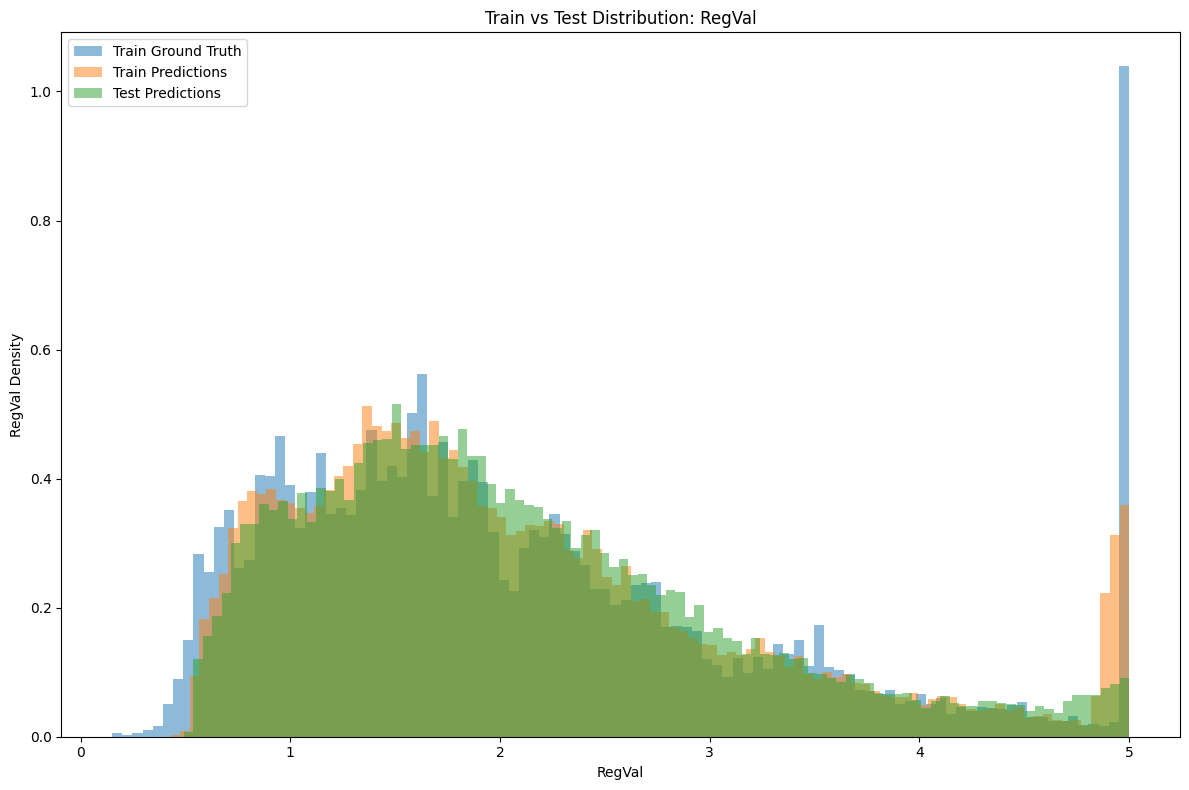

In [ ]:
""" histogram the train_ground_truth, train_pred, and test_pred """
# include the entire training + validation set
train_pred = model.predict(X, num_iteration=model.best_iteration)  
train_pred = np.clip(train_pred, FLOOR, CAP)



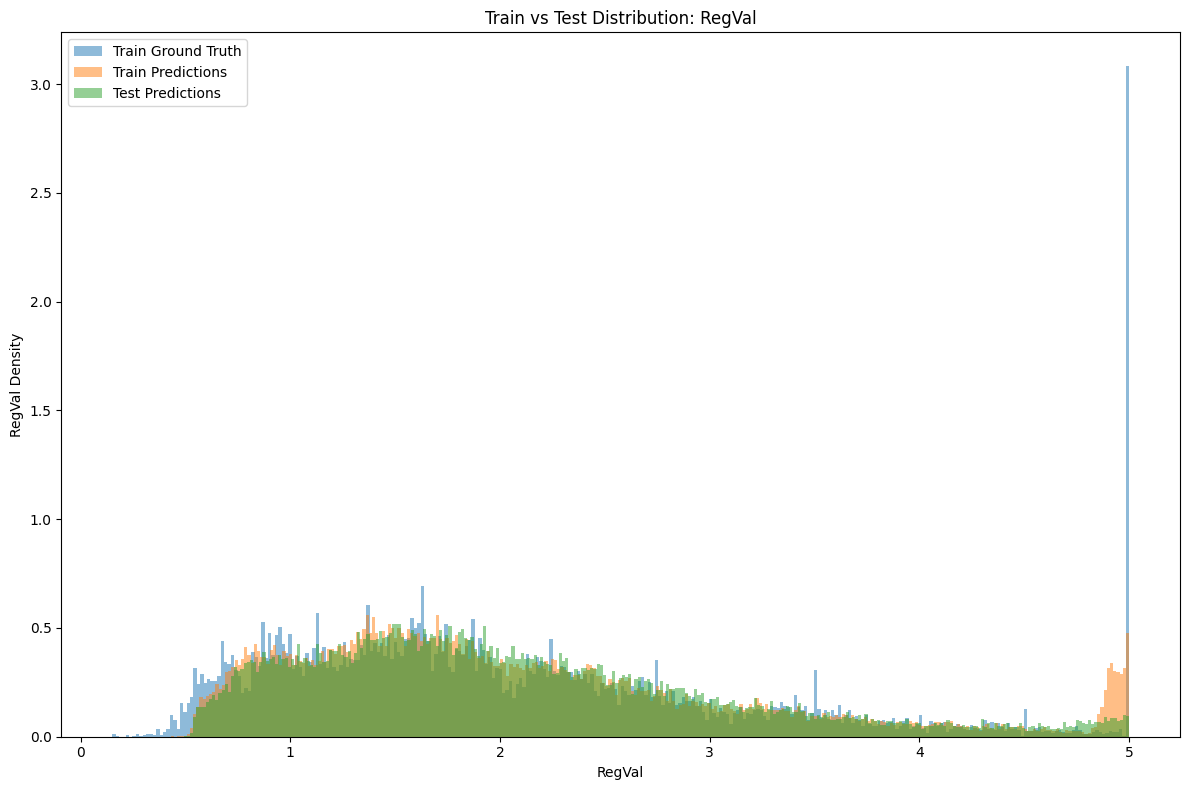

In [8]:

plt.figure(figsize=(12, 8))
plt.hist(y_train, bins=300, alpha=0.5, label="Train Ground Truth", density=True)
plt.hist(train_pred, bins=300, alpha=0.5, label="Train Predictions", density=True)
plt.hist(test_pred, bins=300, alpha=0.5, label="Test Predictions", density=True)
plt.title(f"Train vs Test Distribution: RegVal")
plt.xlabel("RegVal")
plt.ylabel(f"RegVal Density")
plt.legend()
plt.tight_layout()

In [7]:
# Save submission
submission_df = pd.DataFrame({"id": test_data.index,"MedHouseVal": test_pred})
submission_df.to_csv("regression-tabular-california-housing/lgbm_submission.csv", index=False)